# Section G. Logistic Regression vs. Bayesian Classifier
## Question 9 [Discriminative vs Generative Models, 25 Marks]

In [1]:
library(ggplot2)
library(mvtnorm)
library(reshape2)

### Q7-1 Load Task2D_train.csv and Task2D_test.csv 

In [2]:
trainT2D <- read.csv('assessments_datasets/Task2D_train.csv', header=TRUE, sep="," )
testT2D <- read.csv('assessments_datasets/Task2D_test.csv', header=TRUE, sep="," )

## Q7-2 Train Bayesian Classifier Model

In [3]:
c0 <- '1'; c1 <- '-1'
for.loop <- seq(5,500,5)
Error <- data.frame(matrix(0,nrow=length(for.loop), ncol=3))
names(Error) <- c('size',"Bayesian Classifier Test Error","Bayesian Classifier Train Error")
Error$size <- for.loop
#testing <- data.frame(matrix(0,nrow=length(for.loop), ncol=2))
#names(training) <- c('size', 'test_error')

In [4]:
for (i in for.loop){
    #print (i)
    train.len <- i
    train.index <- seq(1:train.len)
    #print (train.index)
    train.data <- trainT2D[train.index, c('x1', 'x2')]; train.label <- trainT2D[train.index, 'y']
    test.data <- testT2D[train.index, c('x1', 'x2')]; test.label <- testT2D[train.index, 'y']
    
    # Class probabilities:
    p0.hat <- sum(train.label==c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat
    
    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])
    
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    #store in accuracy table
    #Error[i/5,][0] <- train.len
    Error[i/5,][3] <-  100-(sum(train.label==train.predict)/nrow(train.data)*100)
    Error[i/5,][2] <-  100-(sum(test.label==test.predict)/nrow(test.data)*100)
}

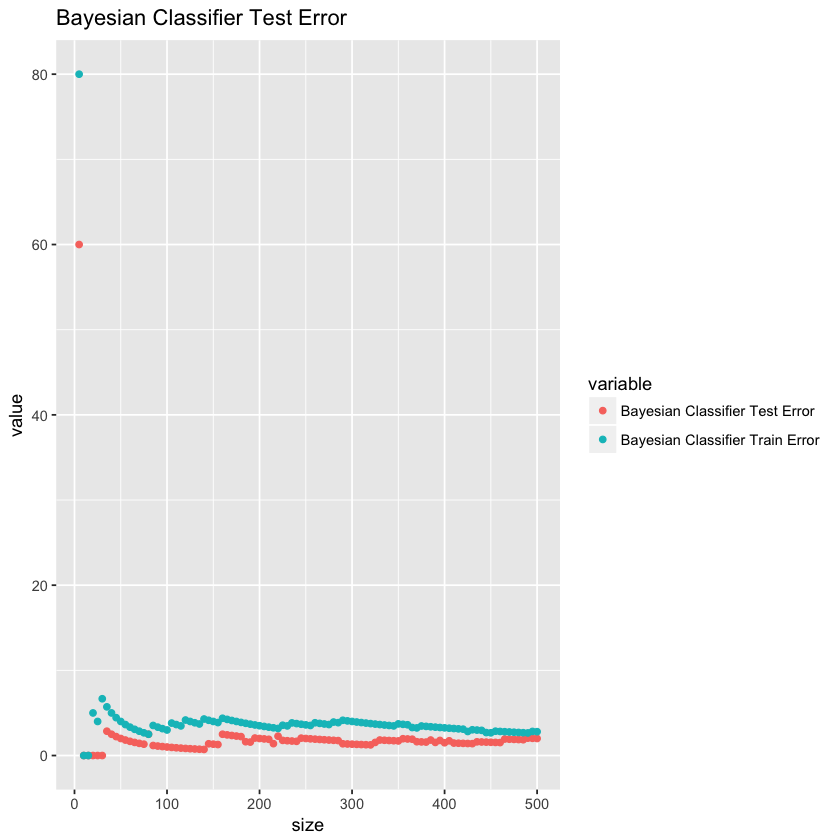

In [19]:
#data <- as.data.frame(cbind(LR_Error,Error[2]))
#bc_data <- as.data.frame(cbind(LR_Error,Error[2]))
bc_data <- melt(Error, id='size')
ggplot(data=bc_data, aes(x=size, y=value, color=variable)) + geom_point() + 
        labs(title='Bayesian Classifier Test Error')# +  theme_minimal()

## Q7-2 Train Logistic Regression Model

In [20]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [21]:
LR_Error <- data.frame(matrix(0,nrow=length(for.loop), ncol=3))
names(LR_Error) <- c('size',"Logistic regression Test Error","Logistic regression Trian Error")
LR_Error$size <- for.loop

In [10]:
for (i in for.loop){
    #print (i)
    train.len <- i
    train.index <- seq(1:train.len)
    #print (train.index)
    train.data <- trainT2D[train.index, c('x1', 'x2')]; train.label <- trainT2D[train.index, 'y']
    test.data <- testT2D[train.index, c('x1', 'x2')]; test.label <- testT2D[train.index, 'y']
    
    # Initializations
    tau.max <- 1500 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    
    while(!terminate){
    # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    #cat('\nThe  final coefficents are:',w)
    
    # store test error
    #pred <- (predict(w,train.data,c0,c1)==train.label)
    #pred.table <- table(unlist((predict(w,train.data,c0,c1)==test.label)))
    LR_Error[i/5,][3] <- table(unlist(factor(predict(w,train.data,c0,c1)==train.label)))[1]/train.len *100
    LR_Error[i/5,][2] <- table(unlist(factor(predict(w,test.data,c0,c1)==test.label)))[1]/train.len *100
    
}

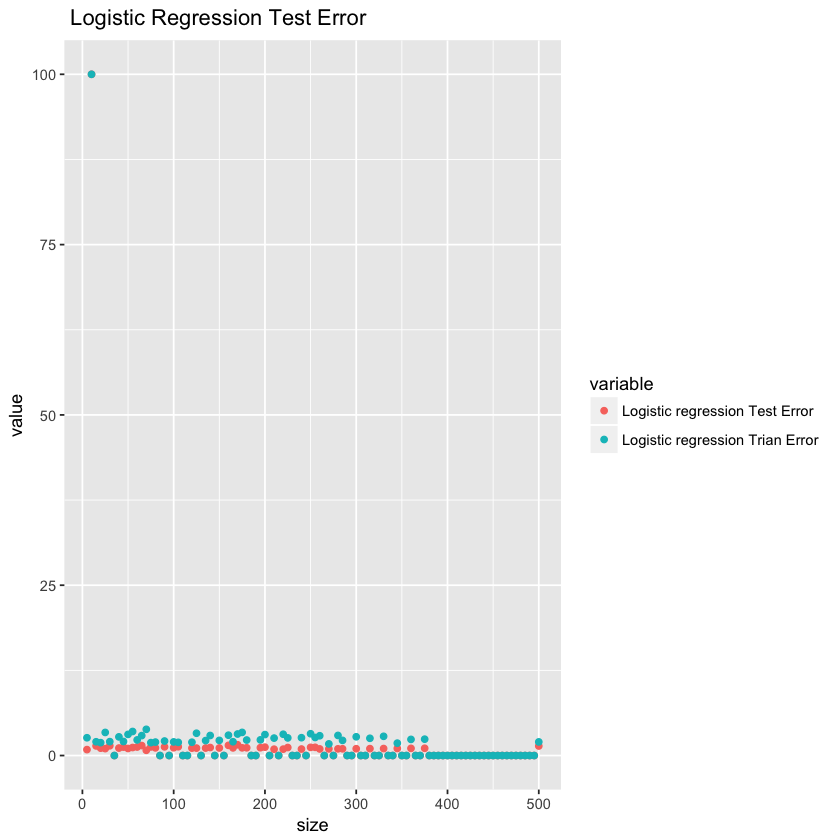

In [18]:
#data <- as.data.frame(cbind(LR_Error,Error[2]))
#bc_data <- as.data.frame(cbind(LR_Error,Error[2]))
lr_data <- melt(LR_Error, id='size')
ggplot(data=lr_data, aes(x=size, y=value, color=variable)) + geom_point() + 
        labs(title=' Logistic Regression Test Error')# +  theme_minimal()

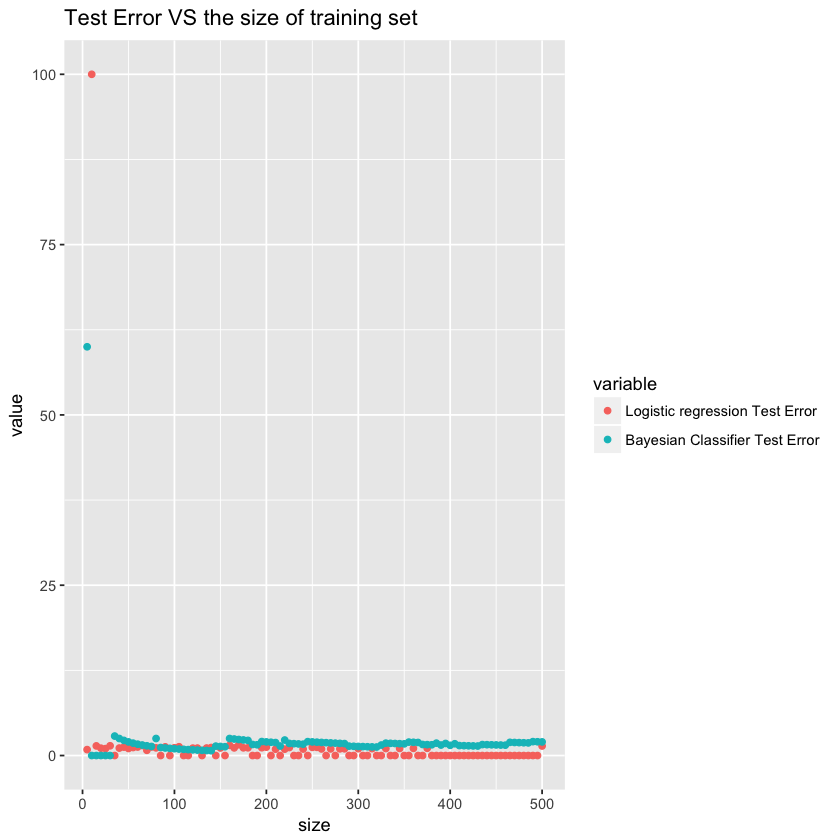

In [17]:
data <- as.data.frame(cbind(Error[1],LR_Error[2],Error[2]))
data.m <- melt(data, id='size')
ggplot(data=data.m, aes(x=size, y=value, color=variable)) + geom_point() + 
        labs(title='Test Error VS the size of training set')# +  theme_minimal()

### Q9-3  Hint: Think about model complexity and the fundamental concepts of machine learning covered in Module 1.

a. What does happen for each classifier when the number of training data points is increased?

Answer： The more train data, the smaller the test error. On the whole, the LR model has fewer test errors, indicating that the lr model is better.

b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

Answer： BC model suits for small size of training set. LR model suits for big size of training set. 

c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.
Answer ：Both the algorithms can be used for classification of the data. BC: For the given features (x) and the label y, it estimates a joint probability from the training data. Hence, works well even with less training data, as the estimates are based on the joint density function.
LR: Estimates the probability(y/x) directly from the training data by minimizing error. Hence, with the small training data, model estimates may over fit the data